# Multi-Element Airfoil

In [75]:
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import logging
logging.getLogger().setLevel(logging.INFO)

In [81]:
# Read and panel airfoil data
MAIN = main_selig = vft.read_selig("main_element.dat")[:,::-1]
# MAIN = vft.repanel(main_selig, N = 200, TEFAC=1.0)[:,::-1] #180

FLAP0 = vft.read_selig("flap.dat")[:,::-1]
# FLAP0 = vft.repanel(vft.read_selig("NLR7301FlapECARP.dat"),220)[:,::-1] #150

The authors note an offset in the change in distance between flap and main airfoil, as well as a change in twist on the flap. 
This change is applied below, by shifting and rotating the flap.
Such a modification was also used in the analysis in [6].

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

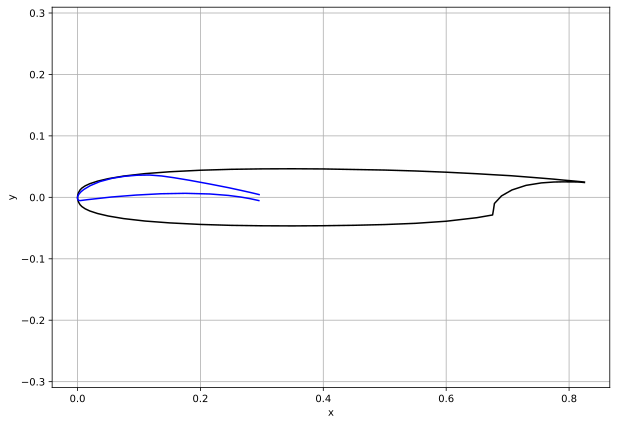

In [82]:
matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

# Rotate flap
center = np.r_[0.94, -0.011]


def rotate(deg, center, x):
    """Rotate airfoil.
    
    Parameters
    ----------
    deg : float
    center : numpy.array
    x : numpy.array
    
    Returns
    -------
    moved : numpy.array
    """

    # Create rotation matrix
    deg2rad = np.pi / 180
    c, s = np.cos(deg * deg2rad), np.sin(deg * deg2rad)
    A = np.array([[c, s], [-s, c]])

    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.
    moved = ((A @ ((x.T - center.T).T)).T + center.T).T
    
    return moved

FLAP = rotate(-0.25, center, FLAP0)
FLAP[1, :] += 0.0025

# Plot geometry
fig, ax = plt.subplots(1, 1)
ax.plot(MAIN[0, :], MAIN[1, :], "-k")
ax.plot(FLAP[0, :], FLAP[1, :], "-b")
ax.axis("equal")
ax.grid()
ax.set(xlabel = "x", ylabel="y")

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [ ]:
# Settings
RE = 2.51e6
ncrit = 8
Mach = 0.0
AOArange = np.arange(start=-2, stop=17, step=0.5)

setup = vf.setup(Re=RE, Ncrit=ncrit, Ma=Mach, Alpha=AOArange[0])
setup.Silent = True  # Do not show information on convergence and iterations

# RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
setup.ShearLagType = 1

results = {}  # Dictionary of results
Mach_vec = [0, 0.185]
res13 = {}
for mach in Mach_vec:

    #  Set Mach number
    setup.Ma = mach

    # When using an outer loop, make sure to re-initialize the solution
    Init = True

    results[mach] = {}
    results[mach]["AOA"] = []
    results[mach]["CL"] = []
    results[mach]["CLi"] = []
    results[mach]["CD"] = []

    for alpha in AOArange:

        setup.Alpha = alpha

        if Init:
            [p, bl, xn] = vf.init([FLAP], setup)
            Init = False

        res = None
        grad = None
        [xn, flag, res, grad, _] = vf.iter(xn, bl, p, setup, res, grad)
        resi = np.sqrt(np.dot(res.T, res))

        if bool(flag) == True:
            results[mach]["AOA"].append(alpha)
            results[mach]["CL"].append(p.CL)
            results[mach]["CLi"].append(p.CLi)
            results[mach]["CD"].append(bl[0].CD)
            #  print('AOA %2.2f CL %f'%(alpha,p.CL))

 xi=0.053414,delta=0.000178,theta=0.000162,ue=0.660586,typ=turbulent,
 res=[-0.0140155,0.0109675,0.000355006]
 dx=[5.48611e-06,-0.011705,-0.000939184]
 x=[0.000162034,0.660586,0.0288323] 
 lam=1.000000 H=1.096474 HS=1.941842 US=0.867997.

 xi=0.053344,delta=0.000099,theta=0.000060,ue=0.968318,typ=turbulent,
 res=[0.0193649,-0.103407,0.000244647]
 dx=[-2.00692e-05,0.0412261,0.0114894]
 x=[6.04251e-05,0.968318,0.0187683] 
 lam=0.272256 H=1.640681 HS=1.728023 US=0.457513.

 xi=0.093608,delta=0.000113,theta=0.000053,ue=1.220092,typ=laminar,
 res=[0.198945,-0.477281,1.50445e-05]
 dx=[-0.000282101,0.37181,0.000280139]
 x=[5.26985e-05,1.22009,7.49949] 
 lam=0.046702 H=2.153442 HS=1.633939 US=0.000000.

 xi=0.013796,delta=0.000030,theta=0.000015,ue=1.564587,typ=laminar,
 res=[1.63139,-2.03299,1.12549e-05]
 dx=[-5.48059e-05,-0.117707,4.67663e-05]
 x=[1.50719e-05,1.56459,5.74655] 
 lam=0.068751 H=1.998896 HS=1.664518 US=0.000000.

 xi=0.013788,delta=0.000030,theta=0.000015,ue=1.526813,typ=lamina

 xi=0.013732,delta=0.000040,theta=0.000018,ue=1.090436,typ=laminar,
 res=[1.10958,-1.79674,8.01514e-06]
 dx=[-0.000683175,-1.99,-8.06719e-06]
 x=[1.76341e-05,1.09044,5.35632] 
 lam=0.006453 H=2.246953 HS=1.618291 US=0.000000.

 xi=0.013744,delta=0.000041,theta=0.000019,ue=1.097751,typ=laminar,
 res=[1.21144,-1.63331,1.6249e-05]
 dx=[-0.000100514,-0.136142,8.84733e-05]
 x=[1.91245e-05,1.09775,5.4361] 
 lam=0.047567 H=2.132354 HS=1.637750 US=0.000000.

 xi=0.013734,delta=0.000041,theta=0.000019,ue=1.086387,typ=laminar,
 res=[1.18059,-1.60648,1.60355e-05]
 dx=[-9.72374e-05,-0.129366,8.54314e-05]
 x=[1.92557e-05,1.08639,5.369] 
 lam=0.049507 H=2.133336 HS=1.637570 US=0.000000.

 xi=0.013703,delta=0.000040,theta=0.000018,ue=1.069349,typ=laminar,
 res=[1.08958,-1.75748,8.12048e-06]
 dx=[-0.000431667,-1.16973,-8.20575e-06]
 x=[1.79434e-05,1.06935,5.26385] 
 lam=0.010392 H=2.241135 HS=1.619207 US=0.000000.

 xi=0.013711,delta=0.000041,theta=0.000019,ue=1.068821,typ=laminar,
 res=[1.11091,-1.63

 xi=0.012920,delta=0.000042,theta=0.000018,ue=0.855673,typ=laminar,
 res=[0.905039,-1.75887,3.72017e-06]
 dx=[-0.00268165,-10.9882,-3.72652e-06]
 x=[1.82566e-05,0.855673,2.89394] 
 lam=0.001702 H=2.294509 HS=1.611069 US=0.000000.

 xi=0.012918,delta=0.000042,theta=0.000018,ue=0.853044,typ=laminar,
 res=[0.912559,-1.75281,3.92798e-06]
 dx=[-0.000390404,-1.57838,-3.97471e-06]
 x=[1.83621e-05,0.853044,3.09318] 
 lam=0.011758 H=2.286900 HS=1.612193 US=0.000000.

 xi=0.012812,delta=0.000040,theta=0.000022,ue=0.890179,typ=laminar,
 res=[0.659643,-1.22557,3.80409e-06]
 dx=[6.25438e-06,0.013023,-9.22442e-06]
 x=[2.20507e-05,0.890179,1.13905] 
 lam=0.587606 H=1.811215 HS=1.711039 US=0.000000.

 xi=0.012973,delta=0.000036,theta=0.000020,ue=1.048156,typ=laminar,
 res=[0.69048,-1.27683,3.47979e-06]
 dx=[6.11712e-06,0.021184,-7.79044e-06]
 x=[2.03086e-05,1.04816,2.81644] 
 lam=0.553326 H=1.796565 HS=1.715169 US=0.000000.

 xi=0.013088,delta=0.000036,theta=0.000022,ue=1.084659,typ=laminar,
 res=[0.8

 xi=0.013048,delta=0.000027,theta=0.000015,ue=1.609088,typ=laminar,
 res=[0.745858,-1.42721,2.07688e-06]
 dx=[4.09334e-06,0.0551201,-5.22722e-06]
 x=[1.48019e-05,1.60909,1.71484] 
 lam=0.602681 H=1.804103 HS=1.713034 US=0.000000.

 xi=0.013049,delta=0.000027,theta=0.000015,ue=1.609154,typ=laminar,
 res=[0.745689,-1.42713,2.07519e-06]
 dx=[4.09156e-06,0.0551322,-5.22547e-06]
 x=[1.48001e-05,1.60915,1.71483] 
 lam=0.602869 H=1.804219 HS=1.713002 US=0.000000.

 xi=0.013071,delta=0.000027,theta=0.000015,ue=1.549523,typ=laminar,
 res=[0.744628,-1.42616,2.17111e-06]
 dx=[4.22565e-06,0.0514151,-5.41233e-06]
 x=[1.51834e-05,1.54952,2.33901] 
 lam=0.598858 H=1.809957 HS=1.711391 US=0.000000.

 xi=0.013070,delta=0.000027,theta=0.000015,ue=1.550186,typ=laminar,
 res=[0.743885,-1.42639,2.15909e-06]
 dx=[4.21259e-06,0.0515458,-5.3992e-06]
 x=[1.51681e-05,1.55019,2.33901] 
 lam=0.600110 H=1.810813 HS=1.711152 US=0.000000.

 xi=0.013071,delta=0.000027,theta=0.000015,ue=1.550540,typ=laminar,
 res=[0.7

 xi=0.012735,delta=0.000028,theta=0.000014,ue=1.383758,typ=laminar,
 res=[0.963171,-1.4458,5.84249e-06]
 dx=[-1.12629e-05,-0.150174,7.89184e-06]
 x=[1.41085e-05,1.38376,0.000125549] 
 lam=0.313164 H=2.019898 HS=1.659986 US=0.000000.

 xi=0.012629,delta=0.000028,theta=0.000013,ue=1.386378,typ=laminar,
 res=[0.857299,-1.66563,4.32079e-06]
 dx=[-1.12715e-05,-0.204594,9.66158e-06]
 x=[1.26503e-05,1.38638,0.000124027] 
 lam=0.280582 H=2.174701 HS=1.630205 US=0.000000.

 xi=0.012619,delta=0.000027,theta=0.000016,ue=1.510472,typ=laminar,
 res=[0.804096,-1.39114,2.35131e-06]
 dx=[7.41738e-06,0.121126,-3.72697e-06]
 x=[1.6427e-05,1.51047,0.000122057] 
 lam=0.369110 H=1.641729 HS=1.763907 US=0.000000.

 xi=0.012616,delta=0.000027,theta=0.000016,ue=1.490274,typ=laminar,
 res=[0.691708,-1.28035,1.99508e-06]
 dx=[4.53758e-06,0.062678,-4.73197e-06]
 x=[1.57467e-05,1.49027,0.000121701] 
 lam=0.578382 H=1.710673 HS=1.741007 US=0.000000.

 xi=0.012619,delta=0.000027,theta=0.000017,ue=1.510244,typ=lamin

 xi=0.012336,delta=0.000047,theta=0.000024,ue=0.594442,typ=laminar,
 res=[0.552203,-0.873781,6.22815e-06]
 dx=[-1.45416e-05,-0.0196424,1.42549e-05]
 x=[2.42436e-05,0.594442,0.000125934] 
 lam=0.416797 H=1.951959 HS=1.675110 US=0.000000.

 xi=0.012529,delta=0.000046,theta=0.000026,ue=0.617750,typ=laminar,
 res=[0.503856,-1.02402,2.14704e-06]
 dx=[5.78609e-06,0.0143128,-8.09168e-06]
 x=[2.55049e-05,0.61775,0.000121853] 
 lam=0.734661 H=1.819528 HS=1.708731 US=0.000000.

 xi=0.012499,delta=0.000045,theta=0.000025,ue=0.637733,typ=laminar,
 res=[0.464649,-0.97303,1.46354e-06]
 dx=[5.16196e-06,0.0157046,-7.13553e-06]
 x=[2.46192e-05,0.637733,0.00012117] 
 lam=0.794893 H=1.846658 HS=1.701366 US=0.000000.

 xi=0.012522,delta=0.000046,theta=0.000025,ue=0.622289,typ=laminar,
 res=[0.481249,-1.00052,1.71058e-06]
 dx=[5.40514e-06,0.0151248,-7.51413e-06]
 x=[2.5048e-05,0.622289,0.000121417] 
 lam=0.772351 H=1.843381 HS=1.702242 US=0.000000.

 xi=0.012496,delta=0.000045,theta=0.000024,ue=0.637813,ty

 xi=0.012413,delta=0.000074,theta=0.000035,ue=0.447796,typ=laminar,
 res=[0.227877,-0.45395,8.844e-06]
 dx=[-3.52972e-05,0.016114,3.52972e-05]
 x=[3.5376e-05,0.447796,0.00012855] 
 lam=0.250558 H=2.094770 HS=1.644815 US=0.000000.

 xi=0.051873,delta=0.000043,theta=0.000019,ue=1.914440,typ=laminar,
 res=[1.52376,-2.52175,8.13517e-06]
 dx=[-0.000186659,-2.34079,-8.34601e-06]
 x=[1.88612e-05,1.91444,9.48813] 
 lam=0.025261 H=2.277797 HS=1.613553 US=0.000000.

 xi=0.012389,delta=0.000075,theta=0.000042,ue=0.435537,typ=laminar,
 res=[0.095008,-0.202586,0]
 dx=[5.85212e-06,-0.00314486,-8.9953e-06]
 x=[4.18333e-05,0.435537,0.000119706] 
 lam=1.000000 H=1.787226 HS=1.717842 US=0.000000.

 xi=0.012378,delta=0.000074,theta=0.000045,ue=0.436029,typ=laminar,
 res=[0.0938473,-0.195097,0]
 dx=[6.54184e-06,-0.00581877,-9.77612e-06]
 x=[4.45628e-05,0.436029,0.000119706] 
 lam=1.000000 H=1.670632 HS=1.754060 US=0.000000.

 xi=0.012334,delta=0.000074,theta=0.000048,ue=0.438471,typ=laminar,
 res=[0.14170

 xi=0.012303,delta=0.000061,theta=0.000034,ue=0.528807,typ=laminar,
 res=[0.128359,-0.271472,0]
 dx=[4.86941e-06,7.94093e-05,-7.32072e-06]
 x=[3.41523e-05,0.528807,0.000119706] 
 lam=1.000000 H=1.795169 HS=1.715566 US=0.000000.

 xi=0.012281,delta=0.000056,theta=0.000035,ue=0.589338,typ=laminar,
 res=[0.199549,-0.373878,9.98325e-07]
 dx=[6.76927e-06,-0.00332695,-7.30524e-06]
 x=[3.50651e-05,0.589338,0.000120704] 
 lam=0.863341 H=1.596281 HS=1.780145 US=0.000000.

 xi=0.012302,delta=0.000049,theta=0.000028,ue=0.699839,typ=laminar,
 res=[0.189143,-0.396688,0]
 dx=[4.51855e-06,0.00377632,-6.3047e-06]
 x=[2.84159e-05,0.699839,0.000119706] 
 lam=1.000000 H=1.716338 HS=1.739214 US=0.000000.

 xi=0.012221,delta=0.000047,theta=0.000022,ue=0.694420,typ=laminar,
 res=[0.390366,-0.808646,5.43938e-06]
 dx=[-1.74768e-05,-0.0353461,1.74768e-05]
 x=[2.17575e-05,0.69442,0.000125145] 
 lam=0.311235 H=2.168976 HS=1.631200 US=0.000000.

 xi=0.012294,delta=0.000040,theta=0.000019,ue=0.870466,typ=laminar,


 xi=0.012406,delta=0.000032,theta=0.000016,ue=1.196293,typ=laminar,
 res=[0.57426,-0.873415,5.35039e-06]
 dx=[-7.9691e-06,-0.0714126,5.31029e-06]
 x=[1.61569e-05,1.19629,0.000125056] 
 lam=0.506861 H=1.982659 HS=1.668109 US=0.000000.

 xi=0.012406,delta=0.000032,theta=0.000016,ue=1.191355,typ=laminar,
 res=[0.559508,-0.885799,5.18938e-06]
 dx=[-7.77541e-06,-0.0702814,5.34471e-06]
 x=[1.60532e-05,1.19136,0.000124895] 
 lam=0.516152 H=1.995700 HS=1.665219 US=0.000000.

 xi=0.012405,delta=0.000032,theta=0.000016,ue=1.186430,typ=laminar,
 res=[0.507491,-0.85149,4.04821e-06]
 dx=[-7.72613e-06,-0.0496779,7.72613e-06]
 x=[1.61928e-05,1.18643,0.000123754] 
 lam=0.523963 H=1.978822 HS=1.668969 US=0.000000.

 xi=0.012406,delta=0.000032,theta=0.000016,ue=1.193707,typ=laminar,
 res=[0.572802,-0.876233,5.3311e-06]
 dx=[-7.94734e-06,-0.0712701,5.31769e-06]
 x=[1.61494e-05,1.19371,0.000125037] 
 lam=0.508011 H=1.984532 HS=1.667691 US=0.000000.

 xi=0.012409,delta=0.000032,theta=0.000016,ue=1.191542,t

 xi=0.012368,delta=0.000032,theta=0.000019,ue=1.188949,typ=laminar,
 res=[0.42287,-0.814824,1.22539e-06]
 dx=[4.64974e-06,0.0336471,-4.05637e-06]
 x=[1.94706e-05,1.18895,0.000120931] 
 lam=0.697909 H=1.652899 HS=1.760058 US=0.000000.

 xi=0.012368,delta=0.000032,theta=0.000019,ue=1.185306,typ=laminar,
 res=[0.409231,-0.79267,1.20439e-06]
 dx=[4.23586e-06,0.0258906,-4.99017e-06]
 x=[1.92811e-05,1.18531,0.00012091] 
 lam=0.758647 H=1.670283 HS=1.754177 US=0.000000.

 xi=0.012370,delta=0.000032,theta=0.000020,ue=1.190135,typ=laminar,
 res=[0.460876,-0.850295,1.59984e-06]
 dx=[5.38671e-06,0.0375543,-4.11657e-06]
 x=[1.97595e-05,1.19013,0.000121306] 
 lam=0.611366 H=1.631961 HS=1.767318 US=0.000000.

 xi=0.012367,delta=0.000032,theta=0.000019,ue=1.181103,typ=laminar,
 res=[0.35279,-0.731013,4.37044e-07]
 dx=[3.44765e-06,0.0272109,-4.44057e-06]
 x=[1.865e-05,1.1811,0.000120143] 
 lam=0.901579 H=1.721751 HS=1.737513 US=0.000000.

 xi=0.012368,delta=0.000032,theta=0.000019,ue=1.181994,typ=lami

 xi=0.012360,delta=0.000032,theta=0.000016,ue=1.197066,typ=laminar,
 res=[0.485761,-0.824382,3.98548e-06]
 dx=[-7.03743e-06,-0.0501291,7.03743e-06]
 x=[1.59419e-05,1.19707,0.000123692] 
 lam=0.566326 H=1.983230 HS=1.667981 US=0.000000.

 xi=0.012359,delta=0.000032,theta=0.000016,ue=1.195460,typ=laminar,
 res=[0.508558,-0.898867,4.57454e-06]
 dx=[-6.8163e-06,-0.066448,5.20472e-06]
 x=[1.55216e-05,1.19546,0.000124281] 
 lam=0.569283 H=2.032119 HS=1.657406 US=0.000000.

 xi=0.012359,delta=0.000032,theta=0.000016,ue=1.200957,typ=laminar,
 res=[0.520804,-0.86282,4.82431e-06]
 dx=[-6.97876e-06,-0.0672066,4.93829e-06]
 x=[1.57364e-05,1.20096,0.00012453] 
 lam=0.563726 H=2.005776 HS=1.663020 US=0.000000.

 xi=0.012359,delta=0.000032,theta=0.000016,ue=1.200957,typ=laminar,
 res=[0.520804,-0.86282,4.82431e-06]
 dx=[-6.97876e-06,-0.0672066,4.93829e-06]
 x=[1.57364e-05,1.20096,0.00012453] 
 lam=0.563726 H=2.005776 HS=1.663020 US=0.000000.

 xi=0.012358,delta=0.000032,theta=0.000015,ue=1.194080,typ

 xi=0.012149,delta=0.000029,theta=0.000016,ue=1.321339,typ=laminar,
 res=[0.214798,-0.451257,0]
 dx=[2.13781e-06,0.0263419,-3.47791e-06]
 x=[1.60495e-05,1.32134,0.000119706] 
 lam=1.000000 H=1.793899 HS=1.715929 US=0.000000.

 xi=0.012149,delta=0.000029,theta=0.000018,ue=1.343753,typ=laminar,
 res=[0.288143,-0.599474,0]
 dx=[2.87517e-06,0.0246956,-3.68782e-06]
 x=[1.76264e-05,1.34375,0.000119706] 
 lam=1.000000 H=1.632852 HS=1.767005 US=0.000000.

 xi=0.012148,delta=0.000029,theta=0.000017,ue=1.332302,typ=laminar,
 res=[0.232564,-0.490091,0]
 dx=[2.39768e-06,0.0247743,-3.59125e-06]
 x=[1.67627e-05,1.3323,0.000119706] 
 lam=1.000000 H=1.716601 HS=1.739131 US=0.000000.

 xi=0.012148,delta=0.000029,theta=0.000018,ue=1.354295,typ=laminar,
 res=[0.354391,-0.712868,0]
 dx=[4.66887e-06,0.0646163,-0]
 x=[1.83091e-05,1.3543,0.000119706] 
 lam=0.653588 H=1.571220 HS=1.789511 US=0.000000.

 xi=0.012148,delta=0.000029,theta=0.000018,ue=1.351797,typ=laminar,
 res=[0.33082,-0.653969,3.88026e-07]
 dx

 xi=0.012172,delta=0.000030,theta=0.000015,ue=1.182258,typ=laminar,
 res=[0.287944,-0.609072,0]
 dx=[2.1508e-06,0.0275777,-0]
 x=[1.53544e-05,1.18226,0.000119706] 
 lam=1.000000 H=1.943912 HS=1.676992 US=0.000000.

 xi=0.012136,delta=0.000030,theta=0.000015,ue=1.150876,typ=laminar,
 res=[0.3804,-0.709217,3.72929e-06]
 dx=[-4.07103e-06,-0.0432165,4.07103e-06]
 x=[1.49172e-05,1.15088,0.000123435] 
 lam=0.916055 H=2.016775 HS=1.660652 US=0.000000.

 xi=0.012141,delta=0.000031,theta=0.000016,ue=1.101842,typ=laminar,
 res=[0.258058,-0.542168,0]
 dx=[2.1567e-06,0.0250066,-3.47584e-06]
 x=[1.60601e-05,1.10184,0.000119706] 
 lam=1.000000 H=1.920299 HS=1.682630 US=0.000000.

 xi=0.012143,delta=0.000031,theta=0.000016,ue=1.076770,typ=laminar,
 res=[0.382846,-0.693113,3.89752e-06]
 dx=[-4.39269e-06,-0.0404163,4.39269e-06]
 x=[1.55901e-05,1.07677,0.000123604] 
 lam=0.887272 H=2.002535 HS=1.663724 US=0.000000.

 xi=0.012148,delta=0.000032,theta=0.000016,ue=1.041417,typ=laminar,
 res=[0.398978,-0.64

 xi=0.011980,delta=0.000025,theta=0.000015,ue=1.537333,typ=laminar,
 res=[0.0775124,-0.163856,0]
 dx=[1.30168e-06,0.0263402,-0]
 x=[1.49832e-05,1.53733,0.000119706] 
 lam=1.000000 H=1.637982 HS=1.765210 US=0.000000.

 xi=0.011980,delta=0.000025,theta=0.000015,ue=1.540605,typ=laminar,
 res=[0.0769063,-0.162607,0]
 dx=[1.29477e-06,0.026354,-6.98121e-07]
 x=[1.49607e-05,1.5406,0.000119706] 
 lam=1.000000 H=1.638414 HS=1.765060 US=0.000000.

 xi=0.011980,delta=0.000024,theta=0.000011,ue=1.509576,typ=laminar,
 res=[0.539972,-1.11877,1.31873e-07]
 dx=[-3.44526e-06,-0.0741614,-6.30073e-07]
 x=[1.08967e-05,1.50958,0.000119838] 
 lam=0.790702 H=2.208054 HS=1.624559 US=0.000000.

 xi=0.011979,delta=0.000024,theta=0.000013,ue=1.609261,typ=laminar,
 res=[0.0181407,-0.0389298,5.91715e-07]
 dx=[-5.91715e-07,-0.0133904,5.91715e-07]
 x=[1.30864e-05,1.60926,0.000120298] 
 lam=1.000000 H=1.806753 HS=1.712289 US=0.000000.

 xi=0.011979,delta=0.000024,theta=0.000014,ue=1.624300,typ=laminar,
 res=[0.029292

 xi=0.011984,delta=0.000021,theta=0.000010,ue=1.771118,typ=laminar,
 res=[0.702713,-1.37279,1.36553e-06]
 dx=[-8.3008e-06,-0.287569,-1.92039e-06]
 x=[9.59342e-06,1.77112,0.000121072] 
 lam=0.288931 H=2.219884 HS=1.622618 US=0.000000.

 xi=0.131484,delta=0.000012,theta=0.000008,ue=169.106899,typ=turbulent,
 res=[0.169105,-0.530782,5.81241e-05]
 dx=[-1.16172e-06,32.6779,0.0054363]
 x=[8.33736e-06,169.107,0.0130493] 
 lam=0.400067 H=1.484217 HS=1.725219 US=0.523548.

 xi=0.050944,delta=0.000018,theta=0.000009,ue=25.283757,typ=turbulent,
 res=[1.39047,-2.81458,0.00180126]
 dx=[-3.08815e-05,32.375,0.00788312]
 x=[8.98612e-06,25.2838,0.0160558] 
 lam=0.072747 H=1.994804 HS=1.625311 US=0.324379.

 xi=0.050574,delta=0.000011,theta=0.000005,ue=42.173126,typ=turbulent,
 res=[2.2467,-3.56335,5.52502e-05]
 dx=[2.18255e-06,-6.77473,-0.000634485]
 x=[5.22453e-06,42.1731,0.0104269] 
 lam=0.398963 H=2.058623 HS=1.615175 US=0.307235.

 xi=0.050465,delta=0.000006,theta=0.000003,ue=78.854455,typ=turbulen

 xi=0.050037,delta=0.000001,theta=0.000000,ue=1301.811765,typ=turbulent,
 res=[13.2732,-26.1136,0.0152802]
 dx=[-2.00555e-07,743.602,-5.9286e-05]
 x=[2.78887e-07,1301.81,0.000142581] 
 lam=0.291780 H=2.688946 HS=1.526434 US=0.185648.

 xi=0.090563,delta=0.000009,theta=0.000002,ue=1568610265582348009472.000000,typ=turbulent,
 res=[-172.165,134.588,0.0296689]
 dx=[2.07213e-07,4.91375e+22,0.0340007]
 x=[1.96669e-06,1.56861e+21,0.0667429] 
 lam=0.005320 H=4.792827 HS=1.850356 US=0.043077.

 xi=0.050252,delta=0.000001,theta=0.000000,ue=754.725885,typ=turbulent,
 res=[9.36137,-21.3488,0.012983]
 dx=[3.09649e-07,-962.644,0.000166431]
 x=[3.9245e-07,754.726,0.000232714] 
 lam=0.196003 H=2.505556 HS=1.546232 US=0.213411.

 xi=0.090643,delta=0.000010,theta=0.000002,ue=878905164285880303616.000000,typ=turbulent,
 res=[-141.032,104.436,0.0255615]
 dx=[2.10656e-07,2.30344e+22,0.0281154]
 x=[2.11137e-06,8.78905e+20,0.0708889] 
 lam=0.006359 H=4.671327 HS=1.841928 US=0.048902.

 xi=0.090651,delta=0.0

 xi=0.131530,delta=0.000031,theta=0.000020,ue=4.848334,typ=turbulent,
 res=[-1.1781,-13.7642,-0.0539281]
 dx=[4.82894e-06,0.664396,-7.43167e-06]
 x=[1.99916e-05,4.84833,1.67772e-07] 
 lam=0.005644 H=1.564974 HS=1.747856 US=0.493810.

 xi=0.131531,delta=0.000031,theta=0.000020,ue=4.828405,typ=turbulent,
 res=[-1.16262,-13.6297,-0.0539389]
 dx=[4.78717e-06,0.652044,-7.38942e-06]
 x=[2.01345e-05,4.8284,1.67772e-07] 
 lam=0.005676 H=1.561431 HS=1.748903 US=0.495633.

 xi=0.131531,delta=0.000032,theta=0.000020,ue=4.800050,typ=turbulent,
 res=[-1.16068,-13.4892,-0.0539474]
 dx=[4.74573e-06,0.64602,-7.3466e-06]
 x=[2.02815e-05,4.80005,1.67772e-07] 
 lam=0.005709 H=1.557776 HS=1.750003 US=0.497529.

 xi=0.131531,delta=0.000032,theta=0.000020,ue=4.774878,typ=turbulent,
 res=[-1.1404,-13.3185,-0.0539606]
 dx=[4.69681e-06,0.630483,-7.29363e-06]
 x=[2.04693e-05,4.77488,1.67772e-07] 
 lam=0.005751 H=1.553301 HS=1.751338 US=0.499859.

 xi=0.131531,delta=0.000032,theta=0.000021,ue=4.736931,typ=turbul

 xi=0.426938,delta=0.000005,theta=0.000004,ue=3.721100,typ=wake,
 res=[-0.00914374,-55.1202,0.000228609]
 dx=[-8.09323e-06,1.96329,0.292824]
 x=[3.61113e-06,3.7211,0.0549756] 
 lam=0.031291 H=1.377030 HS=1.813228 US=0.607541.

 xi=0.426938,delta=0.000005,theta=0.000004,ue=3.716926,typ=wake,
 res=[-0.00882408,-53.7207,0.000228474]
 dx=[-7.78465e-06,1.88601,0.284628]
 x=[3.62312e-06,3.71693,0.0544208] 
 lam=0.031867 H=1.370263 HS=1.815809 US=0.612329.

 xi=0.426938,delta=0.000005,theta=0.000004,ue=3.682827,typ=wake,
 res=[-0.00995462,-45.873,-0.000107949]
 dx=[-6.66995e-06,1.58018,0.262486]
 x=[3.75002e-06,3.68283,0.0540052] 
 lam=0.034291 H=1.322292 HS=1.834774 US=0.647987.

 xi=0.426938,delta=0.000005,theta=0.000004,ue=3.680034,typ=wake,
 res=[-0.00963367,-44.8828,-0.000107224]
 dx=[-6.23332e-06,1.47593,0.247462]
 x=[3.758e-06,3.68003,0.0535642] 
 lam=0.036076 H=1.317791 HS=1.836615 US=0.651495.

 xi=0.426938,delta=0.000005,theta=0.000004,ue=3.715914,typ=wake,
 res=[-0.00874534,-53.373

 xi=0.426938,delta=0.000002,theta=0.000001,ue=5.659541,typ=wake,
 res=[0.0140029,-1732.83,-0.000222209]
 dx=[-2.67267e-06,2.22909,0.123805]
 x=[6.92867e-07,5.65954,0.0986329] 
 lam=0.064810 H=2.589254 HS=1.571539 US=0.204690.

 xi=0.426938,delta=0.000003,theta=0.000002,ue=3.963810,typ=wake,
 res=[-0.0200908,-181.463,-0.000292715]
 dx=[-3.43837e-06,1.32742,0.157957]
 x=[2.23399e-06,3.96381,0.0715324] 
 lam=0.075477 H=1.551397 HS=1.753817 US=0.501402.

 xi=0.479085,delta=0.000000,theta=0.000000,ue=39.256958,typ=wake,
 res=[-0.537699,-1.21018e+08,-0.000577351]
 dx=[-1.18231e-12,5.47931,-9.14666e-06]
 x=[8.85484e-11,39.257,8.58993e-08] 
 lam=0.002348 H=1.030445 HS=1.980951 US=0.955217.

 xi=0.479085,delta=0.000000,theta=0.000000,ue=39.256967,typ=wake,
 res=[-0.537698,-1.21018e+08,-0.00057735]
 dx=[-1.18231e-12,5.47931,-9.14665e-06]
 x=[8.85484e-11,39.257,8.58993e-08] 
 lam=0.002348 H=1.030445 HS=1.980951 US=0.955217.

 xi=0.479085,delta=0.000000,theta=0.000000,ue=41.951799,typ=wake,
 res=[

 xi=0.384713,delta=0.000002,theta=0.000001,ue=4.743502,typ=wake,
 res=[-0.00591237,-198.553,-0.000189675]
 dx=[-3.00058e-07,0.202656,0.0315885]
 x=[1.25261e-06,4.7435,0.0787566] 
 lam=0.415534 H=1.350028 HS=1.823665 US=0.626995.

 xi=0.384713,delta=0.000001,theta=0.000000,ue=5.869841,typ=wake,
 res=[0.0304788,-5416.61,-8.66608e-05]
 dx=[-4.01215e-06,4.75967,0.417695]
 x=[3.41681e-07,5.86984,0.127748] 
 lam=0.021290 H=2.969548 HS=1.544483 US=0.155148.

 xi=0.384713,delta=0.000001,theta=0.000001,ue=4.928663,typ=wake,
 res=[-0.00833523,-304.758,-0.000113062]
 dx=[2.40206e-07,-0.206645,-0.0230735]
 x=[1.0464e-06,4.92866,0.0821369] 
 lam=0.726040 H=1.397774 HS=1.805453 US=0.593214.

 xi=0.426938,delta=0.000000,theta=0.000000,ue=6.883894,typ=wake,
 res=[-0.261071,-96.9863,-0.00202049]
 dx=[-1.3346e-08,0.650855,-1.90516e-06]
 x=[4.33765e-07,6.88389,2.81475e-08] 
 lam=0.003694 H=1.065119 HS=1.960275 US=0.907941.

 xi=0.384713,delta=0.000001,theta=0.000000,ue=5.853549,typ=wake,
 res=[0.0303978,

 xi=0.384713,delta=0.000001,theta=0.000000,ue=5.205945,typ=wake,
 res=[0.0140608,-2611.9,-5.73803e-05]
 dx=[1.57815e-07,-0.166784,-0.0154773]
 x=[4.87264e-07,5.20594,0.117994] 
 lam=0.514594 H=2.353721 HS=1.595978 US=0.245030.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=322.910668,typ=wake,
 res=[-0.065366,-3.75252e+15,-0.00254493]
 dx=[-2.88944e-07,322.577,-4.33986e-06]
 x=[1.49058e-07,322.911,1.80144e-08] 
 lam=0.001038 H=0.000000 HS=1.999999 US=-2386343.516642.

 xi=0.352410,delta=0.000013,theta=0.000003,ue=4.193178,typ=wake,
 res=[1.20592,-77.9859,-0.00523794]
 dx=[-5.93578e-05,-6.1992,-0.304333]
 x=[3.18843e-06,4.19318,0.0264823] 
 lam=0.013429 H=3.995863 HS=1.520001 US=0.073490.

 xi=0.541152,delta=0.000000,theta=0.000001,ue=77853.676727,typ=wake,
 res=[18.3962,-1.55648e+13,1.27878e-05]
 dx=[-1.21668e-05,77525.3,-7.78962e-09]
 x=[5.42525e-07,77853.7,1.32141e-10] 
 lam=0.004241 H=0.000000 HS=1.999999 US=-8685734.689175.

 xi=0.384713,delta=0.000001,theta=0.000001,ue=5.584621,ty

 xi=0.426938,delta=0.000002,theta=0.000001,ue=6.278410,typ=wake,
 res=[-0.00633437,-2013.96,-0.00021152]
 dx=[-3.7056e-06,4.85993,0.201476]
 x=[6.29637e-07,6.27841,0.0985721] 
 lam=0.042479 H=2.680411 HS=1.563801 US=0.191309.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=93055.530065,typ=wake,
 res=[11.2682,-1.30575e+13,-0.000180574]
 dx=[-3.47752e-09,92619.1,-5.5309e-05]
 x=[2.15367e-10,93055.5,2.75694e-06] 
 lam=0.012462 H=0.000000 HS=1.999999 US=-3451.669718.

 xi=0.541152,delta=0.000000,theta=0.000001,ue=150190.418363,typ=wake,
 res=[20.7435,-8.09021e+12,-0.000290984]
 dx=[-1.40105e-11,376636,-3.98123e-06]
 x=[1e-06,150190,2.09715e-07] 
 lam=0.013169 H=0.000000 HS=1.999999 US=-16031579.912945.

 xi=0.541152,delta=0.000000,theta=0.000001,ue=157551.991707,typ=wake,
 res=[20.3102,-7.71219e+12,1.93036e-06]
 dx=[-1.80126e-05,156165,-4.43788e-12]
 x=[6.4e-07,157552,2.39644e-12] 
 lam=0.008883 H=0.000000 HS=1.999999 US=-10260209.758737.

 xi=0.541152,delta=0.000000,theta=0.000001,ue=1373

 xi=0.541152,delta=0.000000,theta=0.000000,ue=37.163534,typ=wake,
 res=[-0.0648039,-3.27174e+16,-0.00256331]
 dx=[-2.92013e-07,37.125,-4.33258e-06]
 x=[1.50597e-07,37.1635,1.80144e-08] 
 lam=0.001039 H=0.000000 HS=1.999999 US=-2415125.343052.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=333489.499328,typ=wake,
 res=[9.12631,-3.64663e+12,2.8072e-05]
 dx=[-2.28347e-10,355731,2.82226e-12]
 x=[1.59048e-11,333489,2.48283e-12] 
 lam=0.017413 H=0.000000 HS=1.999999 US=-254.077667.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=248301.461992,typ=wake,
 res=[8.02668,-4.89775e+12,1.53943e-05]
 dx=[-6.28793e-11,309613,-3.84742e-12]
 x=[4.67681e-12,248301,7.30588e-12] 
 lam=0.018594 H=0.000000 HS=1.999999 US=-74.005606.

 xi=0.426938,delta=0.000000,theta=0.000000,ue=17.264114,typ=wake,
 res=[0.700417,-3.20213e+06,-0.00121981]
 dx=[-3.42028e-08,-4.16163,0.100543]
 x=[8.95247e-09,17.2641,0.0359637] 
 lam=0.059616 H=2.761419 HS=1.557630 US=0.180284.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=32

 xi=0.541152,delta=0.000000,theta=0.000000,ue=130.194653,typ=wake,
 res=[-0.0586482,-9.35189e+15,-0.00213383]
 dx=[-2.74785e-07,130.028,-2.81111e-06]
 x=[1.41195e-07,130.195,1.44115e-08] 
 lam=0.001282 H=0.000000 HS=1.999999 US=-2265907.580269.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=132.227339,typ=wake,
 res=[-0.0520192,-9.20413e+15,-0.00182663]
 dx=[-2.59167e-07,132.024,-1.4973e-06]
 x=[1.32649e-07,132.227,9.22337e-09] 
 lam=0.001540 H=0.000000 HS=1.999999 US=-2128295.445312.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=330.452227,typ=wake,
 res=[-0.0269678,-3.68559e+15,-0.000301592]
 dx=[-1.56232e-08,327.97,-4.36774e-09]
 x=[7.79931e-09,330.452,1.32923e-10] 
 lam=0.007608 H=0.000000 HS=1.999999 US=-125180.118419.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=114.742139,typ=wake,
 res=[-0.0592507,-1.06143e+16,-0.00276966]
 dx=[-3.24819e-07,114.622,-3.42437e-06]
 x=[1.67031e-07,114.742,1.44115e-08] 
 lam=0.001052 H=0.000000 HS=1.999999 US=-2680887.715418.

 xi=0.426938,delta

 xi=0.541152,delta=0.000000,theta=0.000000,ue=132.815021,typ=wake,
 res=[0.0474886,-9.178e+15,-0.000178428]
 dx=[-6.43563e-09,132.402,-8.33557e-06]
 x=[3.12185e-09,132.815,1.07374e-07] 
 lam=0.003220 H=0.000000 HS=1.999999 US=-50127.417278.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=128.599028,typ=wake,
 res=[0.0528746,-9.47889e+15,-0.000189284]
 dx=[-7.47954e-09,128.209,-5.48795e-06]
 x=[3.61936e-09,128.599,6.87195e-08] 
 lam=0.003130 H=0.000000 HS=1.999999 US=-58116.018140.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=101.563737,typ=wake,
 res=[0.0571089,-1.20021e+16,-0.00019631]
 dx=[-8.18964e-09,101.264,-4.51423e-06]
 x=[3.95549e-09,101.564,5.49756e-08] 
 lam=0.003045 H=0.000000 HS=1.999999 US=-63513.337334.

 xi=0.541152,delta=0.000000,theta=0.000000,ue=116.006928,typ=wake,
 res=[0.0585199,-1.05078e+16,-0.000198176]
 dx=[-8.37236e-09,115.667,-4.55e-06]
 x=[4.04115e-09,116.007,5.49756e-08] 
 lam=0.003021 H=0.000000 HS=1.999999 US=-64888.929813.

 xi=0.541152,delta=0.000000,th

 xi=0.479085,delta=0.000000,theta=0.000000,ue=60353.350624,typ=wake,
 res=[12.6353,-6.55677e+12,-0.0182877]
 dx=[-4.42781e-10,248269,-0.194985]
 x=[1.66015e-11,60353.4,0.171337] 
 lam=0.009373 H=0.000000 HS=1.999999 US=-82.913700.

 xi=0.426938,delta=0.000000,theta=0.000000,ue=5650.038382,typ=wake,
 res=[10.7209,-1.34891e+18,-0.0116563]
 dx=[-6.48951e-10,5570.87,-0.13823]
 x=[3.82898e-11,5650.04,0.15893] 
 lam=0.014751 H=0.000000 HS=1.999999 US=-48334.023799.

 xi=0.426938,delta=0.000000,theta=0.000000,ue=8469.100173,typ=wake,
 res=[9.31525,-9.00174e+17,-0.00492382]
 dx=[-1.1888e-10,8350.66,-0.0585312]
 x=[7.85967e-12,8469.1,0.069917] 
 lam=0.016529 H=0.000000 HS=1.999999 US=-9922.096145.

 xi=0.426938,delta=0.000000,theta=0.000000,ue=7311.699858,typ=wake,
 res=[9.95845,-1.04321e+18,-0.00678562]
 dx=[-3.06592e-10,7205.83,-0.0805768]
 x=[1.9254e-11,7311.7,0.0954614] 
 lam=0.015700 H=0.000000 HS=1.999999 US=-24314.137557.

 xi=0.426938,delta=0.000000,theta=0.000000,ue=4702.076586,typ=wak

 xi=0.028248,delta=0.000037,theta=0.000013,ue=4.192976,typ=laminar,
 res=[-0.869718,0.274688,-4.17445e-16]
 dx=[-1.23537e-06,1.16005,4.17445e-16]
 x=[1.27294e-05,4.19298,6.41432] 
 lam=0.602411 H=2.928170 HS=1.599117 US=0.000000.

 xi=0.028252,delta=0.000037,theta=0.000013,ue=3.490366,typ=laminar,
 res=[-1.43959,0.408339,-4.17445e-16]
 dx=[4.89937e-05,-43.2677,4.17445e-16]
 x=[1.34491e-05,3.49037,6.42479] 
 lam=0.020167 H=2.768583 HS=1.590862 US=0.000000.

 xi=0.028417,delta=0.000040,theta=0.000013,ue=4.600653,typ=laminar,
 res=[-0.0817493,0.0105728,-4.17445e-16]
 dx=[-3.44518e-07,0.269702,4.17445e-16]
 x=[1.28194e-05,4.60065,6.72274] 
 lam=1.000000 H=3.116160 HS=1.601285 US=0.000000.

 xi=0.028391,delta=0.000039,theta=0.000012,ue=4.758896,typ=laminar,
 res=[-0.531045,0.104963,-4.17445e-16]
 dx=[5.01662e-07,-0.383509,4.17445e-16]
 x=[1.24627e-05,4.7589,6.70482] 
 lam=1.000000 H=3.120916 HS=1.613092 US=0.000000.

 xi=0.028392,delta=0.000039,theta=0.000013,ue=4.508465,typ=laminar,
 res=[

In [ ]:
pd.DataFrame(results[0]).set_index("AOA").plot(subplots=True, grid=True)

In [80]:
# Read experimental data
EXPRES=np.genfromtxt("NLRLIFTSLOPE.csv",delimiter=",",names=True)

fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['MEAS_X'],EXPRES['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Lift")
for val in Mach_vec:
    ax[0].plot(np.array(results[val]["AOA"]),np.asarray(results[val]["CL"]),marker=None,label="Calculation Mach %g"%val)
ax[0].plot(np.array(results[val]["AOA"]),results[val]["CLi"],marker=None,label="Inviscid Lift")

ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].legend()
ax[0].set_xlim([-2, 17])
ax[0].set_ylim([1.5, 3.5])

EXPRESD=np.genfromtxt("NLRDRAGSLOPE.csv",delimiter=",",names=True)
ax[1].plot(EXPRESD['MEAS_X'],EXPRESD['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Drag")
for val in Mach_vec:
    ax[1].plot(results[val]["AOA"],results[val]["CD"],marker=None,label="Calculation Mach %g"%val)

ax[1].set_ylim([0, 0.08]) 
ax[1].set_xlim([-2, 17])
ax[1].set_xlabel('AOA')
ax[1].set_ylabel('CD')
ax[1].legend();

OSError: NLRLIFTSLOPE.csv not found.

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [6]:
# Set-up and initialize based on inviscid panel solution
s.Ma = 0.0

# Experimental 6° has the same lift as numerical 5.5°
s.Alpha = 6
[p6,bl6,x] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl6,p6,s,None,None)

# Experimental 13.1° has the same lift as numerical 12.6°
s.Alpha = 13.1
[p13,bl13,_] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl13,p13,s,None,None)

Exception: Number of airfoils (2) exceeds available (1) this version of viiflow

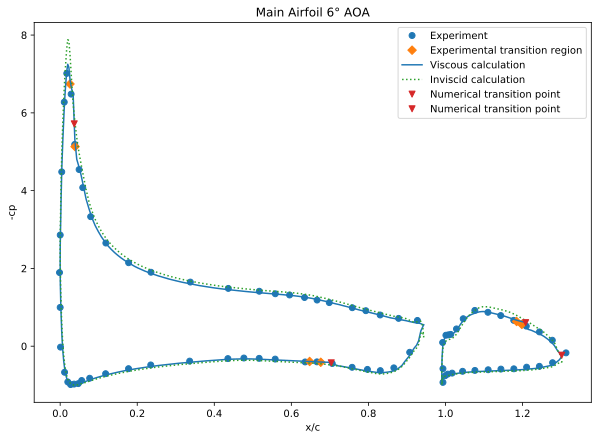

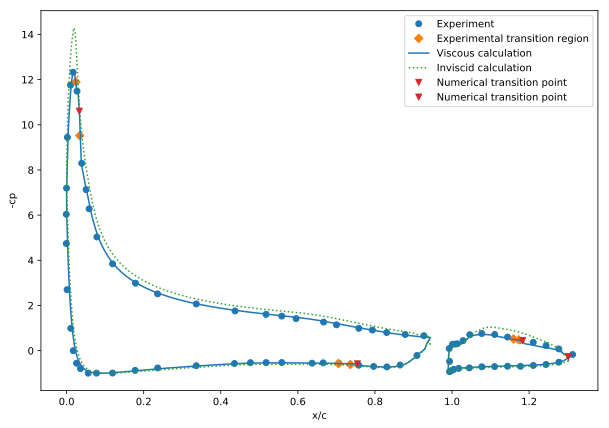

In [6]:

# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax,EXPRES):
    ax.plot(EXPRES['EXPMAINCP_X'],EXPRES['EXPMAINCP_Y'],marker="o",linestyle = 'None', color="tab:blue",label="Experiment")
    ax.plot(EXPRES['EXPFLAPCP_X']+.1,EXPRES['EXPFLAPCP_Y'],marker="o",linestyle = 'None', color="tab:blue")
    ax.plot(EXPRES['EXPMAINTR_X'],EXPRES['EXPMAINTR_Y'],marker="D",linestyle = 'None', color="tab:orange",label="Experimental transition region")
    ax.plot(EXPRES['EXPFLAPTR_X']+.1,EXPRES['EXPFLAPTR_Y'],marker="D",linestyle = 'None', color="tab:orange")

# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax,p,bl):
    # A helper index, cp is a single array of pressures over all panel nodes
    IMF = [range(0,p.foils[0].N),range(p.foils[0].N,p.foils[0].N+p.foils[1].N)]
    
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp[IMF[0]],marker="None",color="tab:blue",label="Viscous calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp[IMF[1]],marker="None",color="tab:blue")
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp_inviscid[IMF[0]],':',marker="None",color="tab:green",label="Inviscid calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp_inviscid[IMF[1]],':',marker="None",color="tab:green")

    for k in range(2):
        tr_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        tr_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        cp_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        cp_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        ax.plot(tr_lo,-cp_lo,'v',color="tab:red",label="Numerical transition point")
        ax.plot(tr_up,-cp_up,'v',color="tab:red")

    ax.set_xlabel('x/c')
    ax.set_ylabel('-cp')

# Read and plot data for 6° AoA
EXPRES=np.genfromtxt("NLRCP55.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
plot_cp_exp(ax,EXPRES)
plot_cp(ax,p6,bl6)
ax.set_title('Main Airfoil 6° AOA')
ax.legend()

# Read and plot data for 13.1° AoA
EXPRES=np.genfromtxt("NLRCP126.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
plot_cp_exp(ax,EXPRES)
plot_cp(ax,p13,bl13)
ax.legend();



[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 